In [1]:
# Importing the necessary packages
import json
import re
import pandas as pd
from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import random
from transformers import GPT2Tokenizer
from transformers import AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer, AdamW
from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.model_selection import train_test_split
import wandb


pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/My Drive/USD-AAI/cleaned_conversational_data_v1.csv")
df.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad again
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with pronunciation if that s okay with you
2,1,3,Not the hacking and gagging and spitting part. Please.,not the hacking and gagging and spitting part please
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,okay then how bout we try out some french cuisine saturday night
4,2,1,You're asking me out. That's so cute. What's your name again?,you re asking me out that s so cute what s your name again


In [4]:
# Drop NaN values in 'cleaned_text'
df = df.dropna(subset=['cleaned_text'])

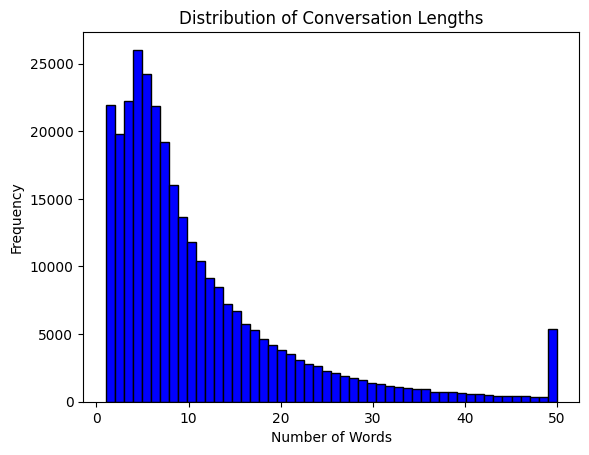

In [5]:
# Extract the cleaned text column for processing:
conversations = df['cleaned_text'].astype(str).tolist()

# Compute conversation lengths
conversation_lengths = [len(text.split()) for text in conversations]

# Plot the histogram of conversation lengths:
plt.hist(conversation_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

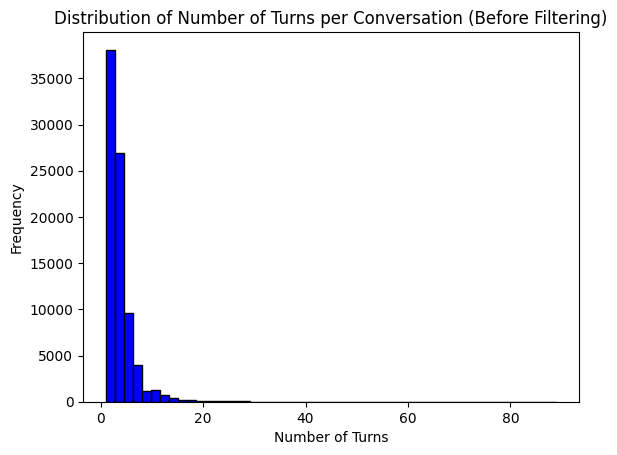

In [6]:
# Group conversations by 'Conversation ID' and count the number of turns per conversation
conversation_turns = df.groupby('Conversation ID').size()

# Plotting a histogram of the number of turns per conversation before filtering
plt.hist(conversation_turns, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Number of Turns per Conversation (Before Filtering)')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.show()

In [7]:
df.shape

(304276, 4)

In [8]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()

83038

In [9]:
# 1. Remove conversations with fewer than 2 turns
conversation_lengths = df.groupby('Conversation ID').size()
valid_conversations = conversation_lengths[conversation_lengths > 1].index
df = df[df['Conversation ID'].isin(valid_conversations)]

In [10]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()

82987

In [11]:
df.shape

(304225, 4)

In [12]:
# 2. Handle short/incomplete text (filter out rows where the cleaned text is too short, e.g., fewer than 5 words)
df = df[df['cleaned_text'].apply(lambda x: len(x.split()) >= 5)]

In [13]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()

77833

In [14]:
df.shape

(214249, 4)

In [15]:
# 3. Calculate conversation lengths (in words) and filter out conversations that are too long
df['conversation_lengths'] = df['cleaned_text'].apply(lambda x: len(x.split()))
upper_limit = np.percentile(df['conversation_lengths'], 90)  # 90th percentile as upper limit

# Remove conversations that are too long (those above the 90th percentile)
df = df[df['conversation_lengths'] <= upper_limit]

# 4. Drop rows where the 'cleaned_text' column is empty or contains only whitespace
df = df[df['cleaned_text'].str.strip().astype(bool)]

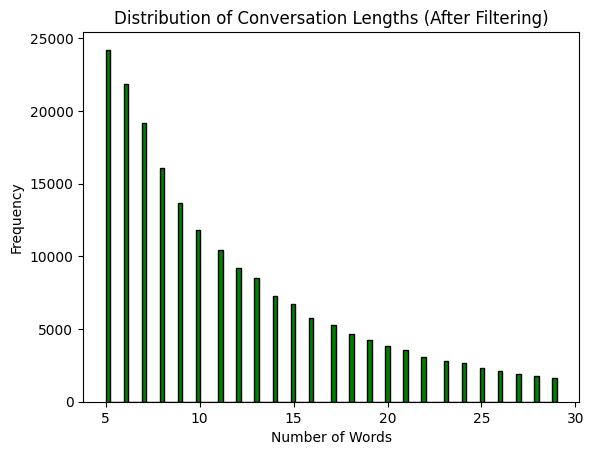

In [16]:
plt.hist(df['conversation_lengths'], bins=100, color='green', edgecolor='black')
plt.title('Distribution of Conversation Lengths (After Filtering)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [17]:
# 5. Inspect the final cleaned dataset (optional)
print(f"Total rows after cleaning: {len(df)}")
df[['Conversation ID', 'Turn ID', 'cleaned_text', 'conversation_lengths']].head()

Total rows after cleaning: 194270


,Conversation ID,Turn ID,cleaned_text,conversation_lengths
0,1,1,can we make this quick Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad again,22
1,1,2,well i thought we d start with pronunciation if that s okay with you,14
2,1,3,not the hacking and gagging and spitting part please,9
3,1,4,okay then how bout we try out some french cuisine saturday night,12
4,2,1,you re asking me out that s so cute what s your name again,14


In [18]:
# Load GPT-2 tokenizer and remove rare words
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Tokenizing conversations to get word counts
word_counts = {}
for text in df['cleaned_text']:
    for word in tokenizer.tokenize(text):
        word_counts[word] = word_counts.get(word, 0) + 1

# Identifying words that occur at least 5 times
threshold = 5
words_to_keep = {word for word, count in word_counts.items() if count >= threshold}

# Function to remove rare words
def remove_rare_words(text):
    return ' '.join([word for word in text.split() if word in words_to_keep])

# Apply the function to remove rare words from 'cleaned_text'
df['cleaned_text'] = df['cleaned_text'].apply(remove_rare_words)

# Drop rows where 'cleaned_text' is empty after removing rare words
df = df[df['cleaned_text'].str.strip().astype(bool)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
df.head()

,Conversation ID,Turn ID,Text,cleaned_text,conversation_lengths
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick and Andrew are having an break up on the again,22
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with if that s with you,14
2,1,3,Not the hacking and gagging and spitting part. Please.,not the and and part please,9
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,then how we try out some night,12
4,2,1,You're asking me out. That's so cute. What's your name again?,you re me out that s so what s your name again,14


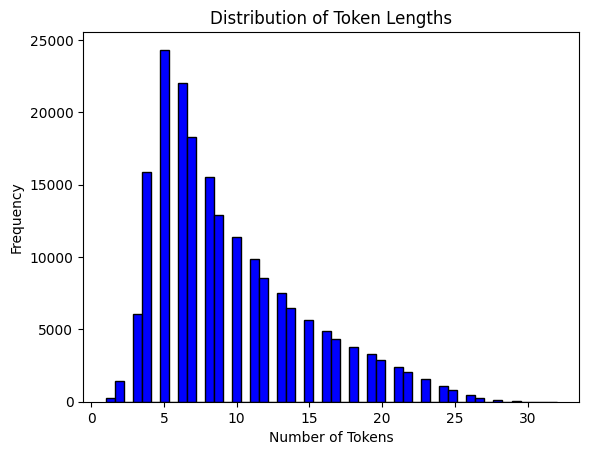

Max token length: 32
90th percentile token length: 17.0
Average token length: 9.509000844472823


In [20]:
df['token_lengths'] = df['cleaned_text'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

# Plot the token length distribution
plt.hist(df['token_lengths'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Print statistics on token lengths
print(f"Max token length: {df['token_lengths'].max()}")
print(f"90th percentile token length: {np.percentile(df['token_lengths'], 90)}")
print(f"Average token length: {df['token_lengths'].mean()}")

In [21]:
df.head()

,Conversation ID,Turn ID,Text,cleaned_text,conversation_lengths,token_lengths
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick and Andrew are having an break up on the again,22,15
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with if that s with you,14,12
2,1,3,Not the hacking and gagging and spitting part. Please.,not the and and part please,9,6
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,then how we try out some night,12,7
4,2,1,You're asking me out. That's so cute. What's your name again?,you re me out that s so what s your name again,14,12


In [22]:
# Add the padding token only once during initialization
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

# Check that padding token has been added
print(f"Pad Token ID: {tokenizer.pad_token_id}")

Pad Token ID: 50257


In [23]:
# Set the tokenizer's pad token to EOS, as GPT-2 doesn't have a pad token by default
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the input data
df['input_ids'] = df['cleaned_text'].apply(
    lambda x: tokenizer.encode(
        x,
        truncation=True,
        padding='max_length',  # Ensure padding to max_length
        max_length=20,         # Adjust max length based on your needs
        add_special_tokens=False  # No extra special tokens added
    )
)

# Check the tokenized data again
df.head()

,Conversation ID,Turn ID,Text,cleaned_text,conversation_lengths,token_lengths,input_ids
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick and Andrew are having an break up on the again,22,15,"[5171, 356, 787, 428, 2068, 290, 6858, 389, 1719, 281, 2270, 510, 319, 262, 757, 50256, 50256, 50256, 50256, 50256]"
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with if that s with you,14,12,"[4053, 1312, 1807, 356, 288, 923, 351, 611, 326, 264, 351, 345, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]"
2,1,3,Not the hacking and gagging and spitting part. Please.,not the and and part please,9,6,"[1662, 262, 290, 290, 636, 3387, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]"
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,then how we try out some night,12,7,"[8524, 703, 356, 1949, 503, 617, 1755, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]"
4,2,1,You're asking me out. That's so cute. What's your name again?,you re me out that s so what s your name again,14,12,"[5832, 302, 502, 503, 326, 264, 523, 644, 264, 534, 1438, 757, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]"


In [24]:
# Split the data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [25]:
# Creating input-output pairs based on conversation turns
def create_input_output_pairs(df):
    conversation_pairs = []
    grouped_conversations = df.groupby('Conversation ID')

    for _, group in grouped_conversations:
        group = group.sort_values(by='Turn ID')
        for i in range(len(group) - 1):
            input_text = group.iloc[i]['input_ids']
            response_text = group.iloc[i + 1]['input_ids']
            conversation_pairs.append((input_text, response_text))

    return conversation_pairs

In [26]:
df[['Conversation ID', 'Turn ID', 'cleaned_text']].head(10)


,Conversation ID,Turn ID,cleaned_text
0,1,1,can we make this quick and Andrew are having an break up on the again
1,1,2,well i thought we d start with if that s with you
2,1,3,not the and and part please
3,1,4,then how we try out some night
4,2,1,you re me out that s so what s your name again
6,3,1,no no it is my we did nt have a
8,3,3,the thing is i m at the of a of my i can not until she does
9,3,4,like she could get a easy enough
11,4,2,she used to be really when she high then it was just like she got of it or something
13,5,1,if only we could find kat a


In [27]:
# Generate input-output pairs for train, validation, and test datasets
train_pairs = create_input_output_pairs(train_df)
val_pairs = create_input_output_pairs(val_df)
test_pairs = create_input_output_pairs(test_df)

# Check the number of pairs generated
print(f"Total train pairs: {len(train_pairs)}")
print(f"Total validation pairs: {len(val_pairs)}")
print(f"Total test pairs: {len(test_pairs)}")

Total train pairs: 84835
Total validation pairs: 2575
Total test pairs: 2498


In [28]:
for i in range(5):  # Check the first 5 pairs
    input_text = tokenizer.decode(train_pairs[i][0], skip_special_tokens=True)
    response_text = tokenizer.decode(train_pairs[i][1], skip_special_tokens=True)
    print(f"Input: {input_text}\nResponse: {response_text}\n")


Input: can we make this quick and Andrew are having an break up on the again
Response: well i thought we d start with if that s with you

Input: well i thought we d start with if that s with you
Response: not the and and part please

Input: not the and and part please
Response: then how we try out some night

Input: no no it is my we did nt have a
Response: like she could get a easy enough

Input: if only we could find kat a
Response: let me see what i can do



In [29]:
import torch
from torch.utils.data import Dataset

# Create a PyTorch Dataset class
class ConversationDataset(Dataset):
    def __init__(self, tokenized_pairs):
        self.data = tokenized_pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, response_ids = self.data[idx]  # Each entry in data is (input_ids, response_ids)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(response_ids, dtype=torch.long)
        }

In [30]:
# Instantiate datasets
train_dataset = ConversationDataset(train_pairs)
val_dataset = ConversationDataset(val_pairs)

In [31]:
# Create DataLoaders
batch_size = 16  # Adjust based on your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Total train batches: {len(train_dataloader)}")
print(f"Total validation batches: {len(val_dataloader)}")

Total train batches: 5303
Total validation batches: 161


In [32]:
# Load the GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2-medium") #gpt2
model.resize_token_embeddings(len(tokenizer))

Embedding(50258, 1024)

In [33]:
# Initialize the optimizer (AdamW)
optimizer = AdamW(model.parameters(), lr=1e-6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
# Initialize WandB
wandb.init(project="gpt-medium-chatbot", name="finetuning")

# Watch the model to log gradients and weights
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aktham-momani81 (aktham-momani81-university-of-san-diego). Use `wandb login --relogin` to force relogin


[]

In [36]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    run_name="gpt-medium-chatbot",  # Unique run name for WandB
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=32,  # Adjust based on your GPU
    per_device_eval_batch_size=32,  # Adjust based on your GPU
    num_train_epochs=3,
    report_to="wandb",  # Reports metrics to WandB
    save_steps=1000,
    save_total_limit=3
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * training_args.num_train_epochs

# Set the number of warmup steps to 10% of the total steps
num_warmup_steps = int(0.1 * total_steps)  # 10% of total steps for warmup

# Create the learning rate scheduler with dynamic warmup steps
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,  # Dynamically calculated warmup steps
    num_training_steps=total_steps      # Total number of training steps
)

In [50]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
# Pass the scheduler to Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,  # Add the data collator here
    optimizers=(optimizer, scheduler)
)

In [52]:
# Start training
trainer.train()

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`labels` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
# Save the model using Hugging Face's save_pretrained method
model.save_pretrained('/content/drive/My Drive/USD-AAI/gpt2_medium_model_v2')

In [ ]:
tokenizer.save_pretrained('/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2')

('/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2/tokenizer_config.json',
 '/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2/special_tokens_map.json',
 '/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2/vocab.json',
 '/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2/merges.txt',
 '/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2/added_tokens.json')

In [ ]:
from transformers import GPT2LMHeadModel, AutoTokenizer


# Load the base GPT-2 model from the directory where it was saved
model = GPT2LMHeadModel.from_pretrained('/content/drive/My Drive/USD-AAI/gpt2_medium_model_v2', trust_remote_code=True)

# Load the tokenizer (assuming you saved the tokenizer as well in a separate directory)
tokenizer = AutoTokenizer.from_pretrained('/content/drive/My Drive/USD-AAI/gpt2_medium_tokenizer_v2')

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [ ]:
from transformers import GPT2LMHeadModel, AutoTokenizer, pipeline

# Create a text generation pipeline using the GPT-2 model and tokenizer
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)  # Use GPU if available

# Function to generate responses with truncation, temperature, and top-k sampling
def generate_response(prompt, max_length=180, temperature=0.7, top_k=50, max_new_tokens=50):
    """Generates a response with improved handling of truncation and diversity."""

    # Ensure the prompt and max_new_tokens together don't exceed the model's context window
    max_prompt_length = max_length - max_new_tokens
    truncated_prompt = tokenizer.decode(tokenizer.encode(prompt, truncation=True, max_length=max_prompt_length))

    response = generator(truncated_prompt,
                          max_length=max_length,
                          max_new_tokens=max_new_tokens,  # Limit the length of the generated response
                          temperature=temperature,  # Control randomness (lower value for less randomness)
                          top_k=top_k,  # Top-k sampling to improve diversity
                          num_return_sequences=1,
                          pad_token_id=tokenizer.eos_token_id)
    return response[0]['generated_text']

def chat_with_model(model, tokenizer):
    # Move model to the correct device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print("Start chatting with the model! (Type 'quit' to exit)")

    while True:
        # Get user input
        user_input = input("You: ")

        if user_input.lower() == 'quit':
            print("Exiting the chat. Goodbye!")
            break

        # Tokenize the user input
        input_ids = tokenizer.encode(user_input, return_tensors='pt')

        # Move input_ids to the same device as the model
        input_ids = input_ids.to(device)

        # Generate model's response with attention mask
        attention_mask = torch.ones(input_ids.shape, device=device)  # Creating an attention mask

        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,  # Pass the attention mask
            max_new_tokens=50,  # Limit the number of new tokens generated
            pad_token_id=tokenizer.eos_token_id,  # Ensure proper padding
            do_sample=True,  # For more randomness in response
            temperature=0.7,  # Adjust to control randomness (lower is more deterministic)
            top_p=0.9,  # Use nucleus sampling to control randomness
        )

        # Decode the output
        response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        print(f"Model: {response}")

In [ ]:
chat_with_model(model, tokenizer)

Start chatting with the model! (Type 'quit' to exit)
You: hi
Model: hi tot
You: hello
Model: hello are you
You: how are you?
Model: how are you?
You: fine
Model: fine s ntt
You: do you have a name?
Model: do you have a name?
You: can we make this quick and Andrew are having an break up on the again
Model: can we make this quick and Andrew are having an break up on the again
You: quit
Exiting the chat. Goodbye!
